# Testing of the wedge

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy 
from scipy.integrate import quadrature
import tensorflow as tf

2022-10-28 20:03:05.201227: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
def read_cbin(filename, bits=32, order='C', dimensions=3, records=False):
        ''' Read a binary file with three inital integers (a cbin file).
        
        Parameters:
                * filename (string): the filename to read from
                * bits = 32 (integer): the number of bits in the file
                * order = 'C' (string): the ordering of the data. Can be 'C'
                        for C style ordering, or 'F' for fortran style.
                * dimensions (int): the number of dimensions of the data (default:3)
                * records (boolean): does the file contain record separators?
                        
        Returns:
                The data as a N dimensional numpy array.
        
        Example:
                > data = read_cbin(filename='nsrc_z6.981.dat')

        '''

        assert(bits ==32 or bits==64)

        f = open(filename)

        #print('Reading cbin file: %s' % filename)

        counter = dimensions+3 if records else dimensions
        header = np.fromfile(f, count=counter, dtype='int32')
        if records: temp_mesh=header[1:4]
        else: temp_mesh=header[0:3]

        datatype = np.float32 if bits == 32 else np.float64
        data = np.fromfile(f, dtype=datatype, count=np.prod(temp_mesh))
        data = data.reshape(temp_mesh, order=order)
        f.close()
        return data

def save_cbin(filename, data, bits=32, order='C'):
        ''' Save a binary file with three inital integers (a cbin file).
        
        Parameters:
                * filename (string): the filename to save to
                * data (numpy array): the data to save
                * bits = 32 (integer): the number of bits in the file
                * order = 'C' (string): the ordering of the data. Can be 'C'
                        for C style ordering, or 'F' for fortran style.
                        
        Returns:
                Nothing
        '''
        #print('Saving cbin file: %s' % filename)
        assert(bits ==32 or bits==64)
        f = open(filename, 'wb')
        mesh = np.array(data.shape).astype('int32')
        mesh.tofile(f)
        datatype = (np.float32 if bits==32 else np.float64)
        data.flatten(order=order).astype(datatype).tofile(f)
        f.close()

In [3]:
def wedge_slope(k_par, z, theta = np.pi / 2, OMm = 0.27, HII_DIM = 200, cell_size = 1.5, buffer_threshold = 1e-10):
    """Computing the wedge slope of k_par giver k_perp.
    
    Args:
        k_par (array or float): k_par values for which the slope is computed
        z (float): redshift of the slope
        theta (float): angle used for sin(theta) pre-factor, use pi/2 for Horizon wedge.
        OMm (float): Omega matter, used for calculating the slope
        
        HII_DIM, cell_size and buffer_threshold : used only for calculating the buffer.
            One could also just specify the buffer, but here it is just to match previous function directly.
            
    Returns:
        k_perp (array or float): k_perp values
        buffer (float): the buffer value
    """

    def one_over_E(z, OMm):
        return 1 / np.sqrt(OMm * (1 + z) ** 3 + (1 - OMm))

    def multiplicative_factor(z, OMm):
        return 1 / one_over_E(z, OMm) / (1 + z) * quadrature(lambda x: one_over_E(x, OMm), 0, z)[0]

    MF = multiplicative_factor(z, OMm)

    k = 2 * np.pi * np.fft.fftfreq(HII_DIM, d=cell_size)
    delta_k = k[1] - k[0]
    bm = np.abs(np.fft.fft(np.blackman(HII_DIM))) ** 2
    buffer = delta_k * (np.where(bm / np.amax(bm) <= buffer_threshold)[0][0] - 1)

    
    k_par = np.sin(theta) * MF * k_perp + buffer

    return k_par, buffer

# Tensorflow version

In [4]:
def ps2D(lc, cell_size, redshifts=None, n_psbins_par=12, n_psbins_perp=12, logk=True, convert_to_delta=True, chunk_skip=None, compute_variance=False, nanmask=None, chunk_size=):
    """Calculating 2D PS for a series of redshifts for one lightcone.

    Args:
        lc (array): lightcone.
        redshifts (list): list of redshifts for which the lightcone has been computed. If `None`, redshifts will not be outputted.
        cell_size (float): simulation voxel size (in Mpc).
        n_psbins_par (int): number of PS bins in LoS direction.
        n_psbins_perp (int): number of PS bins in sky-plane direction.
        logk (bool): if `True` the binning is logarithmic, otherwise it is linear.
        convert_to_delta (bool): either to convert from power to non-dimensional delta.
        chunk_skip (int): in redshift dimension of the lightcone,
            PS is calculated on chunks `chunk_skip` apart.
            Eg. `chunk_skip = 2` amounts in taking every second redshift bin
            into account. If `None`, it amounts to the lightcone sky-plane size.
        compute_variance (bool): Either to compute variance in each PS bin or not.
        nanmask (array): mask defining which parts of the lightcone (in u, v, z coordinates)
            are measured and which are not, i.e. NaNs. Ignored in the case of `None`.

    Returns:
        PS (dict or array): power spectrum and its sample variance for all redshift bins.
            If `convert_to_delta is True`, returns `{"delta": array, "var_delta": array}`,
            otherwise, returns `{"power": array, "var_power": array}`.
            Moreover, if `compute_variance is False`, only "delta" or "power" array is returned.
        k_values_perp (array): centers of k_perp bins.
        k_values_par (array): centers of k_par bins.
        zs: redshifts, only if `redshifts` were given.
    """
    PS, k_values_perp, k_values_par, zs = _power_2D(lc, redshifts=redshifts, cell_size=cell_size, n_psbins_par=n_psbins_par, n_psbins_perp=n_psbins_perp, logk=logk, chunk_skip=chunk_skip, nanmask=nanmask, compute_variance=compute_variance)

    # TODO: correct the dimension of the meshgrid
    if convert_to_delta is True:
        k_values_cube = np.meshgrid(k_values_par, k_values_perp)  # all k_values on the 2D grid
        conversion_factor = (k_values_cube[1] ** 2 * k_values_cube[0]) / (4 * np.pi**2)  # pre-factor k_perp**2 * k_par
        conversion_factor = conversion_factor[np.newaxis, ...]
    else:
        conversion_factor = 1

    if compute_variance:
        PS_out = {"delta": PS["power"] * conversion_factor, "var_delta": PS["var_power"] * conversion_factor**2}
    else:
        PS_out = PS["power"] * conversion_factor

    if redshifts is None:
        return PS_out, k_values_perp, k_values_par
    else:
        return PS_out, k_values_perp, k_values_par, zs


# TODO: calculate mean values of ks in the code, not as geometrical mean
def _power_2D(lightcone, redshifts, cell_size, n_psbins_par, n_psbins_perp, logk, chunk_skip, nanmask, compute_variance):
    HII_DIM = lightcone.shape[0]
    n_slices = lightcone.shape[-1]
    chunk_skip = HII_DIM if chunk_skip is None else chunk_skip
    chunk_indices = list(range(0, n_slices + 1 - HII_DIM, chunk_skip))
    print(chunk_indices,  n_slices + 1 - HII_DIM, chunk_skip)
    epsilon = 1e-12

    # DFT frequency modes
    k = np.fft.fftfreq(HII_DIM, d=cell_size)
    k = 2 * np.pi * k
    # ignoring 0 and negative modes
    k_min, k_max = k[1], np.abs(k).max()
    # maximal perp mode will be k_max * sqrt(2)
    if logk:
        k_bins_perp = np.logspace(np.log10(k_min - epsilon), np.log10(np.sqrt(2.0) * k_max + epsilon), n_psbins_perp + 1)
 
        # maximal par mode will be k_max
        k_bins_par = np.logspace(np.log10(k_min - epsilon), np.log10(k_max + epsilon), n_psbins_par + 1)
    else:
        k_bins_perp = np.linspace(k_min - epsilon, k_max + epsilon, n_psbins_perp + 1)
        k_bins_par = np.linspace(k_min - epsilon, k_max + epsilon, n_psbins_par + 1)

    # grid of all k_values, where k_cube[0], k_cube[1] are perp values, and k_cube[2] par values
    k_cube = np.meshgrid(k, k, k)
    
    # calculating k_perp, k_par in cylindrical coordinates
    k_cylinder = [np.sqrt(k_cube[0] ** 2 + k_cube[1] ** 2), np.abs(k_cube[2])]
    
    # return a bin index across flattened k_cylinder, for perp and par
    k_perp_digits = np.digitize(k_cylinder[0].flatten(), k_bins_perp)
    k_par_digits = np.digitize(k_cylinder[1].flatten(), k_bins_par)
    
    # construct a unique digit counter for a 2D PS array
    # for first k_perp uses range [1, n_psbins_par]
    # for second k_perp uses range [n_psbins_par + 1, 2 * n_psbins_par] etc.
    k_cylinder_digits = (k_perp_digits - 1) * n_psbins_par + k_par_digits

    # now cut out outsiders: zeros, n_psbins_par + 1, n_psbins_perp + 1
    k_cylinder_digits = np.where(np.logical_or(k_perp_digits == 0, k_par_digits == 0), 0, k_cylinder_digits)
    k_cylinder_digits = np.where(np.logical_or(k_perp_digits == n_psbins_perp + 1, k_par_digits == n_psbins_par + 1), n_psbins_perp * n_psbins_par + 1, k_cylinder_digits)
    k_binsum = np.bincount(k_cylinder_digits, minlength=n_psbins_par * n_psbins_perp + 2)[1:-1]
    
    # geometrical means for values
    k_values_perp = np.sqrt(k_bins_perp[:-1] * k_bins_perp[1:])
    k_values_par = np.sqrt(k_bins_par[:-1] * k_bins_par[1:])

    lightcones = []  # all chunks that need to be computed
    nanmasks = []
    zs = []  # all redshifts that will be xomputed

    # appending all chunks together
    for i in chunk_indices:
        start = i
        end = i + HII_DIM
        lightcones.append(lightcone[..., start:end])
        if nanmask is not None:
            nanmasks.append(nanmask[..., start:end])
        if redshifts is not None:
            zs.append(redshifts[(start + end) // 2])

    V = (HII_DIM * cell_size) ** 3
    dV = cell_size**3

    def _power(box):
        FT = np.fft.fftn(box) * dV
        PS_box = np.real(FT * np.conj(FT)) / V

        # calculating average power as a bin count with PS as weights
        p = (np.bincount(k_cylinder_digits, weights=PS_box.flatten(), minlength=n_psbins_par * n_psbins_perp + 2,)[1:-1] / k_binsum).reshape(n_psbins_perp, n_psbins_par)

        # calculating average square of the power, used for estimating sample variance
        if compute_variance:
            p_sq = (np.bincount(k_cylinder_digits, weights=PS_box.flatten() ** 2, minlength=n_psbins_par * n_psbins_perp + 2,)[1:-1] / k_binsum).reshape(n_psbins_perp, n_psbins_par)
            return dict(power=p, var_power=p_sq - p**2)
        else:
            return dict(power=p, var_power=np.zeros(p.shape))

    def _power_nanmask(box, nanm):
        FT = np.fft.fft2(box, axes=(0, 1))
        FT = np.where(nanm, FT, np.nan)
        FT = np.fft.fft(FT, axis=-1) * dV
        PS_box = np.real(FT * np.conj(FT)) / V
        nans = np.isnan(PS_box)

        k_nan_binsum = np.bincount(k_cylinder_digits, weights=(~nans.flatten()).astype(np.float32), minlength=n_psbins_par * n_psbins_perp + 2)[1:-1]
        PS_box = np.where(nans, 0.0, PS_box)

        # calculating average power as a bin count with PS as weights
        p = (np.bincount(k_cylinder_digits, weights=PS_box.flatten(), minlength=n_psbins_par * n_psbins_perp + 2)[1:-1] / k_nan_binsum).reshape(n_psbins_perp, n_psbins_par)
        
        # calculating average square of the power, used for estimating sample variance
        if compute_variance:
            p_sq = (np.bincount(k_cylinder_digits, weights=PS_box.flatten()** 2, minlength=n_psbins_par * n_psbins_perp + 2)[1:-1] / k_nan_binsum).reshape(n_psbins_perp, n_psbins_par)
            return dict(power=p, var_power=p_sq - p**2)
        else:
            return dict(power=p, var_power=np.zeros(p.shape))

    if nanmask is not None:
        res = [_power_nanmask(lcs, nms) for lcs, nms in zip(lightcones, nanmasks)]
    else:
        res = [_power(lcs) for lcs in lightcones]

    res = {k: np.stack([o[k] for o in res], axis=0) for k in res[0].keys()}
    return res, k_values_perp, k_values_par, zs

In [9]:
lc = np.load("/store/ska/sk09/test_wedge/dT2_21cm_i0.npy")
lc_fg_noise = np.load("/store/ska/sk09/test_wedge/dT4_21cm_i0.npy")
fg = np.load("/store/ska/sk09/test_wedge/dTfrg_21cm_i0.npy")

redshifts = np.loadtxt("/store/ska/sk09/segunet/test/lc_redshifts.txt", dtype = float)

In [25]:
cell_size = 2.
ps_lc, k_values_perp, k_values_par, zs = ps2D(lc, cell_size=cell_size, redshifts=redshifts, n_psbins_par=12, n_psbins_perp=12, logk=False, convert_to_delta=False,chunk_skip=None, compute_variance=False, nanmask=None)

[0, 128, 256, 384] 425 128


In [26]:
dTfrg_sb = lc[...,100:179]
BH = np.load('/store/ska/sk09/test_wedge/BM79_scipy.npy')
dTfrg_BH = dTfrg_sb * BH
sub_redshifts = redshifts[100:179]

ps_lc_fg_noise_cleaned, k_values_perp, k_values_par, zs = ps2D(dTfrg_BH, cell_size=cell_size, redshifts=sub_redshifts, n_psbins_par=12, n_psbins_perp=12, logk=False, convert_to_delta=False,chunk_skip=None, compute_variance=False, nanmask=None)

plt.imshow(np.log10(ps_lc_fg_noise_cleaned[0].T), origin = "lower", vmin=-1, vmax=7, interpolation="none", extent=[k_values_perp[0], k_values_perp[-1], k_values_par[0], k_values_par[-1]])
plt.colorbar(label = "$\log_{10} \, \Delta(k_{perp}, k_{par})$")
plt.plot(k_perp, k_par, color = "red")
plt.xlabel("$k_{perp}$")
plt.ylabel("$k_{par}$")
plt.xscale('log'), plt.yscale('log')
plt.xlim(k_values_perp[0], k_values_perp[-1])
plt.ylim(k_values_par[0], k_values_par[-1])

[] -48 128


IndexError: list index out of range

In [6]:
i = 0
path_input = '/store/ska/sk09/segunet/inputs/dataLC_128_train_190922/'
path_out = '/scratch/snx3000/mibianco/test_wedge/'

dT = read_cbin('%sdata/dT_21cm_i%d.bin' %(path_input, i))
dT2 = read_cbin('%sdata/dT2_21cm_i%d.bin' %(path_input, i))
dT3 = read_cbin('%sdata/dT3_21cm_i%d.bin' %(path_input, i))
dT3gf = read_cbin('%sdata/dT4_21cm_i%d.bin' %(path_input, i))
#dT3exgf = read_cbin('%sdata/dT3exgf_21cm_i%d.bin' %(path_input, i))

#dTf = read_cbin('%sdata/dT3f_21cm_i%d.bin' %(path_input, i))
#dTfn = read_cbin('%sdata/dT3fn_21cm_i%d.bin' %(path_input, i))
xHI = read_cbin('%sdata/xHI_21cm_i%d.bin' %(path_input, i))
mask_xH = read_cbin('%sdata/xH_21cm_i%d.bin' %(path_input, i))
redshifts = np.loadtxt('%slc_redshifts.txt' %path_input)

In [27]:
OMm = 0.27
HII_DIM = 128
chunk_length = 129
cell_size = 2.0

MF = tf.constant([multiplicative_factor(z, OMm) for z in redshifts], dtype = tf.float32)
k_cube, delta_k = calculate_k_cube(HII_DIM, chunk_length, cell_size)
print(MF.shape)
BM, buffer = calculate_blackman(chunk_length, delta_k)
#BH = scipy.signal.windows.blackmanharris(chunk_length)
#BM = tf.convert_to_tensor(np.load('%sBM%d_scipy.npy' %(path_out, chunk_length)))
print(BM.shape)

(552,)
(1, 1, 129)


dTgf


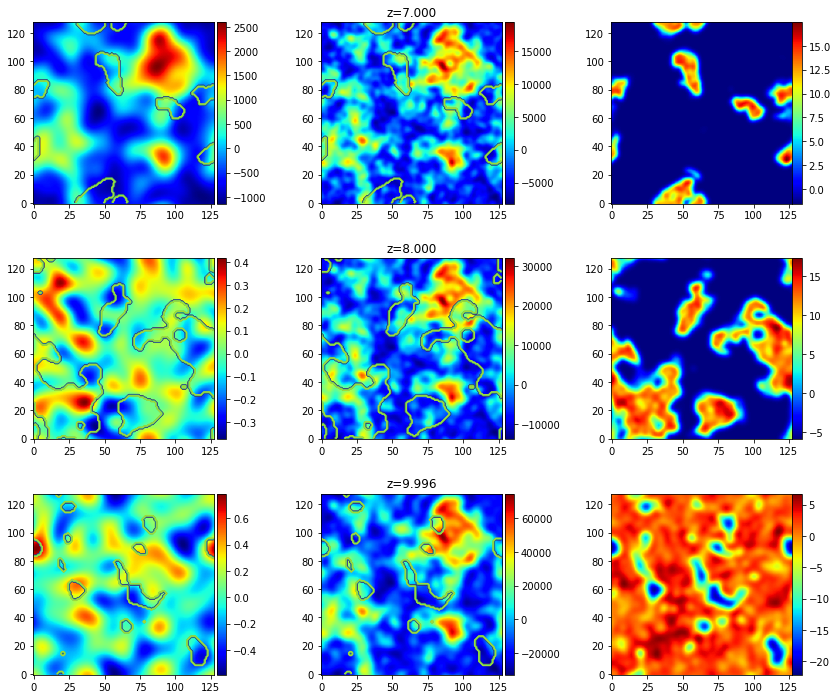

<Figure size 432x288 with 0 Axes>

In [15]:
#var_arr = ['dT3', 'dT3gf', 'dT3exgf', 'dTfn']
var_arr = ['dTgf']
arr_plot = [np.argmin(np.abs(redshifts - search_z)) for search_z in [7, 8, 10]]
#arr_plot = [0, 1, 2]

for var in var_arr:
    if(var == 'dT3'):
        data = dT3
    elif(var == 'dTgf'):
        data = dT3gf
    elif(var == 'dT3exgf'):
        data = dT3exgf
    elif(var == 'dTfn'):
        data = dTfn
    
    Box = tf.constant(data, dtype = tf.float32)
    data_W_tf = wedge_removal_tf(OMm, redshifts, HII_DIM, cell_size, Box, chunk_length, blackman=True, MF=MF, k_cube_data=(k_cube, delta_k), blackman_data=(BM, buffer))
    np.save('%swdg_21cm.npy' %(path_out+var), data_W_tf)
    
    fig, axs = plt.subplots(3, 3, figsize=(15,12), facecolor='white')

    for i, i_plot in enumerate(arr_plot):
        ax1, ax2, ax3 = axs[i]
        #ax1.set_title('wedgeTF data')
        im = ax1.imshow(data_W_tf[..., i_plot], origin='lower', cmap='jet')
        ax1.contour(mask_xH[..., i_plot])
        plt.colorbar(im, ax=ax1, pad=0.01, fraction=0.048)
        ax2.set_title('z=%.3f' %redshifts[i_plot])
        #ax2.set_title('data')
        ax2.contour(mask_xH[..., i_plot])
        im = ax2.imshow(data[..., i_plot], origin='lower', cmap='jet')
        plt.colorbar(im, ax=ax2, pad=0.01, fraction=0.048)
        im = ax3.imshow(dT2[..., i_plot], origin='lower', cmap='jet')
        #ax3.set_title('dT2')
        plt.colorbar(im, ax=ax3, pad=0.0, fraction=0.048)
        plt.subplots_adjust(wspace=0.1, hspace=0.3)
    plt.savefig('%swedge_comparison_%s.png' %(path_out, var), bbox_inches='tight')
    print(var)
    plt.show()
    plt.clf()